In [96]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [97]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
    Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

In [98]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [99]:
# config
NUM_CLIENTS = 20
NUM_ROUNDS = 10
DROPOUT = 0.3
BATCHSIZE = 14
LR = 0.001
epochs_round = 1

In [100]:
data_dir = '/kaggle/input/mri-dataset/datasetzip/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [101]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

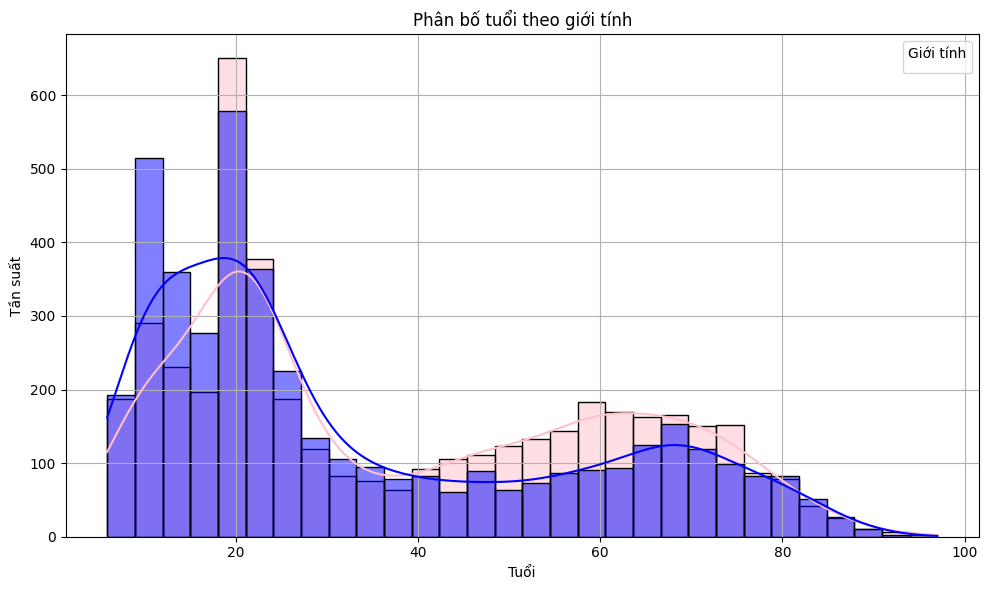

In [102]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
label_ls = label_ls.dropna(subset=['subject_age'])

plt.figure(figsize=(10, 6))

sns.histplot(data=label_ls, x="subject_age", hue="subject_sex", bins=30, kde=True, 
             palette={"m": "blue", "f": "pink"}, edgecolor="black", discrete=False)

plt.title('Phân bố tuổi theo giới tính')
plt.xlabel('Tuổi')
plt.ylabel('Tần suất')
plt.legend(title='Giới tính')
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66.0
23210,m,sub-BrainAge023210,RocklandSample,69.0
23211,m,sub-BrainAge023211,RocklandSample,23.0
23212,f,sub-BrainAge023212,RocklandSample,54.0


In [104]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

8717

In [105]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        label = self._get_label(subject_id)
        image = torch.from_numpy(im).unsqueeze(0)  # Shape: (1, H, W, D)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
        
    def num_classes(self):
        class_set = set()
        for idx in range(len(self)):
            _, label = self[idx]
            class_set.add(label.item())
        return len(class_set)    

In [106]:
def create_global_bin_pool(data: MRIDataset) -> dict:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array([
        subject_metadata.get(sid, {}).get("subject_age", np.nan)
        for sid in subject_ids
    ], dtype=np.float32)

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)

    global_bin_pool = {}
    for bin_id in np.unique(age_bins):
        bin_indices = valid_indices[age_bins == bin_id]
        global_bin_pool[bin_id] = set(bin_indices.tolist())

    return global_bin_pool


def get_sample_data(
    data: MRIDataset,
    overlap: float,
    partition_id: int,
    num_partitions: int,
    global_bin_pool: dict,
    num_samples: int = None,
) -> list:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)
    total_samples = len(valid_indices)
    client_sample_count = total_samples // num_partitions

    rng = np.random.default_rng(seed=partition_id + 42)
    sampled_indices = set()
    used_bins = set()

    all_bins = list(global_bin_pool.keys())
    rng.shuffle(all_bins)
    target_num_bins = max(1, int(overlap * len(all_bins)))

    # Vòng lặp đến khi đủ sample
    while len(sampled_indices) < client_sample_count:
        # Chọn bin chưa dùng
        candidate_bins = [b for b in all_bins if b not in used_bins]
        if not candidate_bins:
            break  # Không còn bin nào để lấy

        selected_bins = candidate_bins[:target_num_bins]
        used_bins.update(selected_bins)

        # Lấy toàn bộ samples từ các bin đã chọn
        combined_indices = []
        for bin_id in selected_bins:
            available = global_bin_pool[bin_id]
            combined_indices.extend(list(available))

        rng.shuffle(combined_indices)

        # Chọn mẫu đến khi đủ
        needed = client_sample_count - len(sampled_indices)
        to_take = combined_indices[:needed]
        sampled_indices.update(to_take)

        # Xoá mẫu đã chọn khỏi global_bin_pool
        for idx in to_take:
            for bin_id in selected_bins:
                global_bin_pool[bin_id].discard(idx)

    if num_samples and num_samples > client_sample_count:
        remaining_needed = num_samples - client_sample_count
        remaining_pool = list(set(valid_indices) - sampled_indices)
        rng.shuffle(remaining_pool)
        extra = remaining_pool[:remaining_needed]
        sampled_indices.update(extra)

    return list(sampled_indices)

In [107]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, overlap: int, global_bin_pool: dict, num_samples=None):
    data = dataset
    sampled_indices = get_sample_data(data=data, overlap=overlap, partition_id=partition_id, num_partitions=num_partitions, 
                                      global_bin_pool=global_bin_pool, num_samples=num_samples)

    np.random.shuffle(sampled_indices)
    train_size = int(0.8 * len(sampled_indices))
    train_indices = sampled_indices[:train_size]
    val_indices = sampled_indices[train_size:]

    train_subset = Subset(data, train_indices)
    val_subset = Subset(data, val_indices)
    return train_subset, val_subset

In [108]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=8, shuffle=False)
    return testloader

In [109]:
import json

def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

In [110]:
im_filenames = load_filenames("/kaggle/input/mri-dataset/mri_dataset.json")

In [111]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames = im_filenames)
len(dataset)

4948

In [112]:
def save_filenames(im_filenames, output_path):
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump([str(path) for path in im_filenames], f)
    print(f"Đã lưu im_filenames vào: {output_path}")

In [113]:
save_filenames(dataset.im_filenames, "mri_dataset.json")

Đã lưu im_filenames vào: mri_dataset.json


In [114]:
from sklearn.model_selection import train_test_split

all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=train_filenames
)

testset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=test_filenames
)

In [115]:
global_bin_pool = create_global_bin_pool(trainset)

In [116]:
class _DenseLayer(nn.Sequential):

    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate,
                 drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)


class _Transition(nn.Sequential):

    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    
    """
    Densenet-BC model class
    
    Args:
        growth_rate (int) - how many filters to add each layer (k in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=2):

        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out,
                                    output_size=(1, 1,
                                                 1)).view(features.size(0), -1)
        logit = self.classifier(out)
        return out, logit

In [117]:
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))

In [118]:
import torch
import torch.nn as nn

class RelaxedBSM(nn.Module):
    def __init__(self, dataloader, num_classes, eps=0.01, device=None):
        super(RelaxedBSM, self).__init__()
        self.num_classes = num_classes
        self.dataloader = dataloader
        self.eps = eps
        
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else "cpu")
        self._cached_prior = None
        self.to(self.device)

    def prior_y(self, recalculate=False):
        if self._cached_prior is not None and not recalculate:
            return self._cached_prior
            
        py = torch.zeros(self.num_classes, device=self.device)
        total_samples = 0
        with torch.no_grad():
            for _, labels in self.dataloader:
                labels = labels.to(self.device)

                if not labels.dtype.is_floating_point:
                    bin_counts = torch.bincount(labels, minlength=self.num_classes).float()
                else:
                    bin_counts = labels.sum(dim=0) if labels.dim() > 1 \
                    else torch.zeros(self.num_classes, device=self.device).scatter_add_(0, labels.long(), torch.ones_like(labels, device=self.device))

                py += bin_counts
                total_samples += labels.size(0)
        self._cached_prior = py / total_samples if total_samples > 0 else torch.ones(self.num_classes, device=self.device) / self.num_classes
        return self._cached_prior

    def smooth_distribution(self, py):
        """Apply smoothing to a probability distribution"""
        py_smooth = (1 - self.eps) * py + self.eps / self.num_classes
        return py_smooth / py_smooth.sum()

    def prior_y_batch(self, labels):
        labels = labels.to(self.device)
        py = torch.bincount(labels, minlength=self.num_classes).float()
        return py / labels.size(0)

    def bsm1(self, logit):
        """Balanced Softmax with global class distribution"""
    
        py = self.prior_y()
        py_smooth = self.smooth_distribution(py)

        logit = logit - logit.max(dim=1, keepdim=True)[0]
        exp_logits = torch.exp(logit)
        
        pc_exp = exp_logits * py_smooth.unsqueeze(0)
        denominator = pc_exp.sum(dim=1, keepdim=True) + 1e-8
        
        return pc_exp / denominator

    def bsm2(self, logit, py):
        """Balanced Softmax with provided class distribution"""
        py = py.to(self.device)
        py_smooth = self.smooth_distribution(py)
        
        logit = logit - logit.max(dim=1, keepdim=True)[0]
        exp_logits = torch.exp(logit)
        
        pc_exp = exp_logits * py_smooth.unsqueeze(0)
        denominator = pc_exp.sum(dim=1, keepdim=True) + 1e-8
        
        return pc_exp / denominator
    
    def forward(self, logit, py=None):
        """Forward method for nn.Module compatibility"""
        if py is None:
            return self.bsm1(logit)
        else:
            return self.bsm2(logit, py)

In [119]:
def get_prototypes(net, dataloader, num_classes, device):
    net.eval()
    prototypes = [[] for _ in range(num_classes)]
    with torch.no_grad():
        for im, labels in dataloader:
            im = im.to(device, non_blocking = True)
            labels = labels.to(device, non_blocking = True)
            features, _ = net(im)
            for i in range(len(labels)):
                prototypes[labels[i].item()].append(features[i])
    class_prototypes = torch.zeros((num_classes, features.shape[1]), device = device)
    for c in range(num_classes):
        if prototypes[c]:
            class_prototypes[c] = torch.stack(prototypes[c]).mean(dim = 0)
        else:
            class_prototypes[c] = torch.zeros(features.shape[1], device = device)
    return class_prototypes

def feature_augmentation(features, labels, prototypes, num_classes, lam=1.0):
    """Perform feature augmentation by transferring intra-class variance to missing classes."""
    aug_features = []
    aug_labels = []
    for i in range(len(labels)):
        src_class = labels[i].item()
        # Cycle through classes for augmentation
        tgt_class = (src_class + 1) % num_classes
        if torch.all(prototypes[tgt_class] == 0):
            continue
        # Compute augmented feature: \tilde{h}_{j,k} = p_j + \lambda (h_{i,k} - p_i)
        aug_feature = prototypes[tgt_class] + lam * (features[i] - prototypes[src_class])
        aug_features.append(aug_feature)
        aug_labels.append(tgt_class)
    
    if aug_features:
        aug_features = torch.stack(aug_features)
        aug_labels = torch.tensor(aug_labels, dtype=torch.long, device=features.device)
        return aug_features, aug_labels
    else:
        return None, None

def save_model_parameters(parameters, file_path: str = "ckpt.pth"):
    if parameters is None:
        print("No parameters available to save.")
        return
    net = model.to(DEVICE)
    final_ndarrays = parameters_to_ndarrays(parameters)
    set_parameters(net, final_ndarrays)
    torch.save(net.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")
    
# Lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# local training
def train(net, trainloader, epochs: int, lr: float, id: int) -> Tuple[float, float]:
    device = next(net.parameters()).device
    num_classes = 2
    nllloss = nn.NLLLoss().to(device)
    rebafl = RelaxedBSM(trainloader, num_classes=num_classes, device=device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
    net.train()
    total_loss = 0.0
    accuracy = 0
    total = 0
    lam = 1
    mu = 0.1

    if device.type == "cuda":
        torch.cuda.synchronize()

    prototypes = get_prototypes(net, trainloader, num_classes, device)
    global_prior = rebafl.prior_y(recalculate=True)
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            features, logits  = net(images)
            balanced_probs = rebafl.bsm1(logits)
            loglikelihood = torch.log(balanced_probs + 1e-8)
            loss0 = nllloss(loglikelihood, labels)
            aug_features, aug_labels = feature_augmentation(features, labels, prototypes, num_classes, lam)
            loss1 = 0.0
            if aug_features is not None:
                aug_logits = net.classifier(aug_features)
                aug_probs = rebafl.bsm1(aug_logits)
                aug_loglikelihood = torch.log(aug_probs + 1e-8)
                loss1 = nllloss(aug_loglikelihood, aug_labels)
            loss = loss0 + mu * loss1
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * labels.size(0)
            predicted = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())

        prototypes = get_prototypes(net, trainloader, num_classes, device)
        avg_epoch_loss = epoch_loss / len(trainloader.dataset)
        avg_epoch_acc = correct / len(trainloader.dataset)
        # print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f} - Accuracy: {avg_epoch_acc:.4f}")
        total_loss += epoch_loss
        accuracy += correct
    
    avg_loss = total_loss / (len(trainloader.dataset) * epochs)
    avg_acc = accuracy / (len(trainloader.dataset) * epochs)
    print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {avg_acc * 100:.2f}%")
    return avg_loss, avg_acc
        

def test(net, testloader, id: int, server_test=False) -> Tuple[float, float]:
    criterion = nn.CrossEntropyLoss()
    net.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            features, outputs = net(images)
            loss += criterion(outputs, labels).item() * labels.size(0)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            progress_bar.set_postfix(loss=loss/total)
    
    avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    if server_test:
        print(f"[Server Test] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    else:
        print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

In [120]:
global_bin_pool = create_global_bin_pool(trainset)

In [121]:
# dropout
def is_dropout(partition_id: int, num_partitions: int) -> bool:
    return random.random() < DROPOUT

# Định nghĩa Client
class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.previous_parameters = None

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: FitIns) -> FitRes:
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return FitRes(
                status=status,
                parameters=ins.parameters,
                num_examples=0,
                metrics={}
            )
        print(f"[Client {self.partition_id}] fit, config: {ins.config}")
            
        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        lr = ins.config.get("lr", 0.001)
        epochs = ins.config.get("epochs", 1)
        
        train_loss, train_accuracy = train(self.net, self.trainloader, epochs=epochs, lr=lr, id=self.partition_id)

        ndarrays_updated = get_parameters(self.net)
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        self.previous_parameters = parameters_updated

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={
                "train_loss": float(train_loss),
                "train_accuracy": float(train_accuracy)
            }
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return EvaluateRes(
                status=status,
                loss=0.0,
                num_examples=0,
                metrics={}
            )

        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(val_loss),
            num_examples=len(self.valloader.dataset),
            metrics={"val_accuracy": float(val_accuracy)}
        )

# Hàm tạo client
def client_fn(context: Context) -> Client:
    net = model.to(DEVICE)
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]
    
    train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
    trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
    
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

In [122]:
# Custom Strategy
class FedCustom(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        net = model
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        standard_config = {"lr": LR,
                           "epochs": epochs_round,
                           "server_round": server_round}
        fit_configurations = []
        for client in clients:
            fit_configurations.append((client, FitIns(parameters, standard_config)))
        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}

        valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
        if not valid_results:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(res.parameters), res.num_examples)
            for _, res in valid_results
        ]
        parameters_aggregated = ndarrays_to_parameters(
            flwr.server.strategy.aggregate.aggregate(weights_results)
        )

        # save model
        if wandb_log:
            if server_round % 2 == 0:
                save_model_parameters(parameters_aggregated, file_path="final_model.pth")

        total_examples = sum(res.num_examples for _, res in valid_results)
        train_loss_agg = sum(
            res.num_examples * res.metrics["train_loss"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0
        train_accuracy_agg = sum(
            res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "train_loss": train_loss_agg,
            "train_accuracy": train_accuracy_agg,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "train_loss": train_loss_agg,
                "train_accuracy": train_accuracy_agg,
                "clients_participated_fit": len(valid_results)
            })

        HISTORY["train_loss"].append(train_loss_agg)
        HISTORY["train_accuracy"].append(train_accuracy_agg)
        HISTORY["clients_participated_fit"].append(len(valid_results))

        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config = {"server_round": server_round}
        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            print(f"Round {server_round}: No results received")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        valid_results = [
            (client_proxy, res) for client_proxy, res in results
            if res.status.code == Code.OK
        ]
        if not valid_results:
            print(f"Round {server_round}: No valid evaluation results")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        total_examples = sum(res.num_examples for _, res in valid_results)
        loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
            [(res.num_examples, res.loss) for _, res in valid_results]
        )
        val_accuracy_aggregated = sum(
            res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "val_loss": loss_aggregated,
            "val_accuracy": val_accuracy_aggregated,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "val_loss": loss_aggregated,
                "val_accuracy": val_accuracy_aggregated,
                "clients_participated_eval": len(valid_results)
            })

        HISTORY["val_loss"].append(loss_aggregated)
        HISTORY["val_accuracy"].append(val_accuracy_aggregated)
        HISTORY["clients_participated_eval"].append(len(valid_results))

        return loss_aggregated, metrics_aggregated

    def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if server_round == 0 or self.evaluate_fn is None:
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        return eval_res

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Hàm đánh giá trên server
def evaluate_fn(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = model.to(DEVICE)
    set_parameters(net, parameters)
    testloader = load_server_test_datasets(data=testset)
    test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

    if wandb_log:
        wandb_logger.log({
            "round": server_round,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        })
    
    HISTORY["test_loss"].append(test_loss)
    HISTORY["test_accuracy"].append(test_accuracy)
    
    return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedCustom(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

In [123]:
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

In [124]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)
wandb_log = True

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [125]:
wandb_logger = wandb.init(
    project="sex-classification",
    name=f"rebafl",
    tags = ['300-samples','DenseNet'],
    config={
        "num_client": NUM_CLIENTS,
        "num_rounds": NUM_ROUNDS,
        "dropout": DROPOUT,
        "learning_rate": LR,
        "architecture": "DenseNet",
        "dataset": "Mri",
        "epochs_round": epochs_round,
    },
)

In [126]:
# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 0}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1

# Khởi tạo HISTORY
HISTORY = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "clients_participated_fit": [],
    "clients_participated_eval": []
}

# Chạy simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

wandb_logger.finish()

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 11 clients (out of 60)
(pid=4615) 2025-05-13 17:17:19.333035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4615) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=4615) E0000 00:00:1747156639.355646    4615 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4615) E0000 00:00:1747156639.362629    4615 cuda_blas.cc:1418] Unable to register cuBLAS factory: A

(ClientAppActor pid=4615) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=4615) [Client 3] Train Loss: 10.1314 | Accuracy: 50.00%
(ClientAppActor pid=4615) [Client 5] dropped out in round 1
(ClientAppActor pid=4615) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=4615) [Client 8] Train Loss: 13.9572 | Accuracy: 26.92%
(ClientAppActor pid=4615) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=4615) [Client 9] Train Loss: 10.4502 | Accuracy: 48.08%
(ClientAppActor pid=4615) [Client 11] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=4615) [Client 11] Train Loss: 12.3631 | Accuracy: 36.54%
(ClientAppActor pid=4615) [Client 32] dropped out in round 1
(ClientAppActor pid=4615) [Client 33] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=4615) [Client 33] Train Loss: 11.0878 | Accuracy: 44.23%
(ClientAppActor

INFO :      aggregate_fit: received 6 results and 5 failures


(ClientAppActor pid=4615) [Client 56] dropped out in round 1


INFO :      fit progress: (1, 673.3347509519018, {'test_accuracy': 0.4393939393939394}, 211.73527739200108)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 673.3348 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 3] dropped out in evaluation round 1
(ClientAppActor pid=4615) [Client 17] dropped out in evaluation round 1
(ClientAppActor pid=4615) [Client 23] dropped out in evaluation round 1
(ClientAppActor pid=4615) [Client 41] evaluate, config: {'server_round': 1}
(ClientAppActor pid=4615) [Client 41] Test Loss: 827.8183 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 38] evaluate, config: {'server_round': 1}
(ClientAppActor pid=4615) [Client 38] Test Loss: 771.3520 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 46] dropped out in evaluation round 1
(ClientAppActor pid=4615) [Client 56] evaluate, config: {'server_round': 1}
(ClientAppActor pid=4615) [Client 56] Test Loss: 543.0610 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 59] evaluate, config: {'server_round': 1}
(ClientAppActor pid=4615) [Client 59] Test Loss: 950.2450 | Accuracy: 15.38%
(ClientAppActor pid=4615) [Client 57] dropped ou

INFO :      aggregate_evaluate: received 41 results and 19 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 33] Test Loss: 787.7597 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 18] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=4615) [Client 18] Train Loss: 12.0443 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 27] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=4615) [Client 27] Train Loss: 12.6819 | Accuracy: 34.62%
(ClientAppActor pid=4615) [Client 31] dropped out in round 2
(ClientAppActor pid=4615) [Client 32] dropped out in round 2
(ClientAppActor pid=4615) [Client 39] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=4615) [Client 39] Train Loss: 10.4502 | Accuracy: 48.08%
(ClientAppActor pid=4615) [Client 44] dropped out in round 2
(ClientAppActor pid=4615) [Client 45] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=4615) [Client 45] Train Loss: 13.6384 | Accuracy: 28.85%
(ClientAppActor pid=4615) [Client 55] fit, c

INFO :      aggregate_fit: received 40 results and 20 failures


(ClientAppActor pid=4615) [Client 53] Train Loss: 12.0443 | Accuracy: 38.46%
Model parameters saved to final_model.pth


INFO :      fit progress: (2, 671.417682193024, {'test_accuracy': 0.4393939393939394}, 893.8179645510008)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 671.4177 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 0] evaluate, config: {'server_round': 2}
(ClientAppActor pid=4615) [Client 0] Test Loss: 633.9307 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 9] evaluate, config: {'server_round': 2}
(ClientAppActor pid=4615) [Client 9] Test Loss: 352.1536 | Accuracy: 69.23%
(ClientAppActor pid=4615) [Client 10] evaluate, config: {'server_round': 2}
(ClientAppActor pid=4615) [Client 10] Test Loss: 577.9193 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 14] evaluate, config: {'server_round': 2}
(ClientAppActor pid=4615) [Client 14] Test Loss: 468.7686 | Accuracy: 61.54%
(ClientAppActor pid=4615) [Client 27] evaluate, config: {'server_round': 2}
(ClientAppActor pid=4615) [Client 27] Test Loss: 573.7688 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 31] evaluate, config: {'server_round': 2}
(ClientAppActor pid=4615) [Client 31] Test Loss: 743.5834 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client

INFO :      aggregate_evaluate: received 43 results and 17 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 7] dropped out in evaluation round 2
(ClientAppActor pid=4615) [Client 10] dropped out in round 3
(ClientAppActor pid=4615) [Client 22] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=4615) [Client 22] Train Loss: 13.6384 | Accuracy: 28.85%
(ClientAppActor pid=4615) [Client 30] dropped out in round 3
(ClientAppActor pid=4615) [Client 33] dropped out in round 3
(ClientAppActor pid=4615) [Client 36] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=4615) [Client 36] Train Loss: 12.0443 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 47] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=4615) [Client 47] Train Loss: 10.7690 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 56] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=4615) [Client 56] Train Loss: 11.7255 | Accuracy: 40.38%
(ClientAppActor pid=4615) [Client 26] dropped out 

INFO :      aggregate_fit: received 40 results and 20 failures


(ClientAppActor pid=4615) [Client 15] dropped out in round 3


INFO :      fit progress: (3, 669.5060594963305, {'test_accuracy': 0.4393939393939394}, 1517.3243297030003)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 669.5061 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 8] evaluate, config: {'server_round': 3}
(ClientAppActor pid=4615) [Client 8] Test Loss: 836.3553 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 14] dropped out in evaluation round 3
(ClientAppActor pid=4615) [Client 21] dropped out in evaluation round 3
(ClientAppActor pid=4615) [Client 28] dropped out in evaluation round 3
(ClientAppActor pid=4615) [Client 30] evaluate, config: {'server_round': 3}
(ClientAppActor pid=4615) [Client 30] Test Loss: 925.3141 | Accuracy: 23.08%
(ClientAppActor pid=4615) [Client 43] evaluate, config: {'server_round': 3}
(ClientAppActor pid=4615) [Client 43] Test Loss: 722.8177 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 46] evaluate, config: {'server_round': 3}
(ClientAppActor pid=4615) [Client 46] Test Loss: 717.5559 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 56] evaluate, config: {'server_round': 3}
(ClientAppActor pid=4615) [Client 56] Test Lo

INFO :      aggregate_evaluate: received 43 results and 17 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 49] Test Loss: 762.6168 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=4615) [Client 1] Train Loss: 10.4502 | Accuracy: 48.08%
(ClientAppActor pid=4615) [Client 4] dropped out in round 4
(ClientAppActor pid=4615) [Client 13] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=4615) [Client 13] Train Loss: 9.1749 | Accuracy: 55.77%
(ClientAppActor pid=4615) [Client 14] dropped out in round 4
(ClientAppActor pid=4615) [Client 16] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=4615) [Client 16] Train Loss: 11.4067 | Accuracy: 42.31%
(ClientAppActor pid=4615) [Client 25] dropped out in round 4
(ClientAppActor pid=4615) [Client 31] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=4615) [Client 31] Train Loss: 11.7255 | Accuracy: 40.38%
(ClientAppActor pid=4615) [Client 53] fit, confi

INFO :      aggregate_fit: received 38 results and 22 failures


(ClientAppActor pid=4615) [Client 50] dropped out in round 4
Model parameters saved to final_model.pth


INFO :      fit progress: (4, 667.6027993558633, {'test_accuracy': 0.4393939393939394}, 2103.474623809001)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 667.6028 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 3] evaluate, config: {'server_round': 4}
(ClientAppActor pid=4615) [Client 3] Test Loss: 362.2923 | Accuracy: 69.23%
(ClientAppActor pid=4615) [Client 21] dropped out in evaluation round 4
(ClientAppActor pid=4615) [Client 22] dropped out in evaluation round 4
(ClientAppActor pid=4615) [Client 27] evaluate, config: {'server_round': 4}
(ClientAppActor pid=4615) [Client 27] Test Loss: 891.9462 | Accuracy: 23.08%
(ClientAppActor pid=4615) [Client 34] evaluate, config: {'server_round': 4}
(ClientAppActor pid=4615) [Client 34] Test Loss: 882.7415 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 40] dropped out in evaluation round 4
(ClientAppActor pid=4615) [Client 44] dropped out in evaluation round 4
(ClientAppActor pid=4615) [Client 46] evaluate, config: {'server_round': 4}
(ClientAppActor pid=4615) [Client 46] Test Loss: 564.0450 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 18] evaluate, c

INFO :      aggregate_evaluate: received 40 results and 20 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 36] Test Loss: 666.2311 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=4615) [Client 0] Train Loss: 11.4067 | Accuracy: 42.31%
(ClientAppActor pid=4615) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=4615) [Client 1] Train Loss: 10.4502 | Accuracy: 48.08%
(ClientAppActor pid=4615) [Client 5] dropped out in round 5
(ClientAppActor pid=4615) [Client 12] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=4615) [Client 12] Train Loss: 11.4067 | Accuracy: 42.31%
(ClientAppActor pid=4615) [Client 16] dropped out in round 5
(ClientAppActor pid=4615) [Client 24] dropped out in round 5
(ClientAppActor pid=4615) [Client 28] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=4615) [Client 28] Train Loss: 10.1314 | Accuracy: 50.00%
(ClientAppActor pid=4615) [Client 55] fit, config

INFO :      aggregate_fit: received 39 results and 21 failures


(ClientAppActor pid=4615) [Client 29] Train Loss: 10.7690 | Accuracy: 46.15%


INFO :      fit progress: (5, 665.703229068024, {'test_accuracy': 0.4393939393939394}, 2762.3674897910005)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 665.7032 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 3] evaluate, config: {'server_round': 5}
(ClientAppActor pid=4615) [Client 3] Test Loss: 376.1241 | Accuracy: 69.23%
(ClientAppActor pid=4615) [Client 17] evaluate, config: {'server_round': 5}
(ClientAppActor pid=4615) [Client 17] Test Loss: 560.7921 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 19] evaluate, config: {'server_round': 5}
(ClientAppActor pid=4615) [Client 19] Test Loss: 506.0847 | Accuracy: 61.54%
(ClientAppActor pid=4615) [Client 45] evaluate, config: {'server_round': 5}
(ClientAppActor pid=4615) [Client 45] Test Loss: 659.4879 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 51] evaluate, config: {'server_round': 5}
(ClientAppActor pid=4615) [Client 51] Test Loss: 662.6664 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 52] dropped out in evaluation round 5
(ClientAppActor pid=4615) [Client 59] evaluate, config: {'server_round': 5}
(ClientAppActor pid=4615) [Client 59

INFO :      aggregate_evaluate: received 44 results and 16 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 33] Test Loss: 441.2963 | Accuracy: 61.54%
(ClientAppActor pid=4615) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=4615) [Client 5] Train Loss: 10.7690 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 7] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=4615) [Client 7] Train Loss: 9.1749 | Accuracy: 55.77%
(ClientAppActor pid=4615) [Client 38] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=4615) [Client 38] Train Loss: 14.2760 | Accuracy: 25.00%
(ClientAppActor pid=4615) [Client 43] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=4615) [Client 43] Train Loss: 11.7255 | Accuracy: 40.38%
(ClientAppActor pid=4615) [Client 45] dropped out in round 6
(ClientAppActor pid=4615) [Client 51] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=4615) [Client 51] Train Loss: 11.4067 | Accuracy: 42.3

INFO :      aggregate_fit: received 42 results and 18 failures


(ClientAppActor pid=4615) [Client 12] Train Loss: 12.0443 | Accuracy: 38.46%
Model parameters saved to final_model.pth


INFO :      fit progress: (6, 663.8087535511364, {'test_accuracy': 0.4393939393939394}, 3385.74958849)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 663.8088 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 16] dropped out in evaluation round 6
(ClientAppActor pid=4615) [Client 23] evaluate, config: {'server_round': 6}
(ClientAppActor pid=4615) [Client 23] Test Loss: 710.2557 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 32] dropped out in evaluation round 6
(ClientAppActor pid=4615) [Client 33] evaluate, config: {'server_round': 6}
(ClientAppActor pid=4615) [Client 33] Test Loss: 562.2162 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 35] evaluate, config: {'server_round': 6}
(ClientAppActor pid=4615) [Client 35] Test Loss: 339.4273 | Accuracy: 69.23%
(ClientAppActor pid=4615) [Client 45] evaluate, config: {'server_round': 6}
(ClientAppActor pid=4615) [Client 45] Test Loss: 769.6202 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 51] dropped out in evaluation round 6
(ClientAppActor pid=4615) [Client 52] evaluate, config: {'server_round': 6}
(ClientAppActor pid=4615) [Client 52] Test 

INFO :      aggregate_evaluate: received 41 results and 19 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 38] Test Loss: 764.7351 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 7] dropped out in round 7
(ClientAppActor pid=4615) [Client 15] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=4615) [Client 15] Train Loss: 11.0878 | Accuracy: 44.23%
(ClientAppActor pid=4615) [Client 19] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=4615) [Client 19] Train Loss: 12.3631 | Accuracy: 36.54%
(ClientAppActor pid=4615) [Client 25] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=4615) [Client 25] Train Loss: 10.4502 | Accuracy: 48.08%
(ClientAppActor pid=4615) [Client 33] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=4615) [Client 33] Train Loss: 11.4067 | Accuracy: 42.31%
(ClientAppActor pid=4615) [Client 41] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=4615) [Client 41] Train Loss: 12.3631 | Accuracy: 

INFO :      aggregate_fit: received 45 results and 15 failures


(ClientAppActor pid=4615) [Client 38] Train Loss: 13.6384 | Accuracy: 28.85%


INFO :      fit progress: (7, 661.9147849959556, {'test_accuracy': 0.4393939393939394}, 4050.0488781290005)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 661.9148 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 13] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 14] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 21] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 30] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 32] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 34] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 46] evaluate, config: {'server_round': 7}
(ClientAppActor pid=4615) [Client 46] Test Loss: 477.2379 | Accuracy: 61.54%
(ClientAppActor pid=4615) [Client 58] evaluate, config: {'server_round': 7}
(ClientAppActor pid=4615) [Client 58] Test Loss: 424.5479 | Accuracy: 61.54%
(ClientAppActor pid=4615) [Client 25] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 51] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 22] evaluate, config: {'server_

INFO :      aggregate_evaluate: received 35 results and 25 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 24] dropped out in evaluation round 7
(ClientAppActor pid=4615) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=4615) [Client 2] Train Loss: 12.6819 | Accuracy: 34.62%
(ClientAppActor pid=4615) [Client 14] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=4615) [Client 14] Train Loss: 12.0443 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 15] dropped out in round 8
(ClientAppActor pid=4615) [Client 16] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=4615) [Client 16] Train Loss: 11.0878 | Accuracy: 44.23%
(ClientAppActor pid=4615) [Client 20] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=4615) [Client 20] Train Loss: 9.1749 | Accuracy: 55.77%
(ClientAppActor pid=4615) [Client 26] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=4615) [Client 26] Train Loss: 10.7690 | Accuracy: 46.15%


INFO :      aggregate_fit: received 36 results and 24 failures


(ClientAppActor pid=4615) [Client 47] dropped out in round 8
Model parameters saved to final_model.pth


INFO :      fit progress: (8, 660.0381880326704, {'test_accuracy': 0.4393939393939394}, 4597.840170072001)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 660.0382 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 34] evaluate, config: {'server_round': 8}
(ClientAppActor pid=4615) [Client 34] Test Loss: 739.3452 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 40] evaluate, config: {'server_round': 8}
(ClientAppActor pid=4615) [Client 40] Test Loss: 846.9576 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 48] dropped out in evaluation round 8
(ClientAppActor pid=4615) [Client 53] dropped out in evaluation round 8
(ClientAppActor pid=4615) [Client 0] dropped out in evaluation round 8
(ClientAppActor pid=4615) [Client 10] evaluate, config: {'server_round': 8}
(ClientAppActor pid=4615) [Client 10] Test Loss: 730.1283 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 21] evaluate, config: {'server_round': 8}
(ClientAppActor pid=4615) [Client 21] Test Loss: 440.0811 | Accuracy: 61.54%
(ClientAppActor pid=4615) [Client 58] dropped out in evaluation round 8
(ClientAppActor pid=4615) [Client 15] evaluate, 

INFO :      aggregate_evaluate: received 41 results and 19 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 14] Test Loss: 620.7047 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 5] dropped out in round 9
(ClientAppActor pid=4615) [Client 15] dropped out in round 9
(ClientAppActor pid=4615) [Client 16] dropped out in round 9
(ClientAppActor pid=4615) [Client 33] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=4615) [Client 33] Train Loss: 10.7690 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 43] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=4615) [Client 43] Train Loss: 12.0443 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 46] dropped out in round 9
(ClientAppActor pid=4615) [Client 48] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=4615) [Client 48] Train Loss: 10.1314 | Accuracy: 50.00%
(ClientAppActor pid=4615) [Client 51] dropped out in round 9
(ClientAppActor pid=4615) [Client 28] dropped out in round 9
(ClientAppActor pid=4615) [Client 13

INFO :      aggregate_fit: received 36 results and 24 failures


(ClientAppActor pid=4615) [Client 55] Train Loss: 12.3631 | Accuracy: 36.54%


INFO :      fit progress: (9, 658.1604521163787, {'test_accuracy': 0.4393939393939394}, 5200.203084864001)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 658.1605 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 10] evaluate, config: {'server_round': 9}
(ClientAppActor pid=4615) [Client 10] Test Loss: 626.2413 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 12] evaluate, config: {'server_round': 9}
(ClientAppActor pid=4615) [Client 12] Test Loss: 865.1566 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 39] evaluate, config: {'server_round': 9}
(ClientAppActor pid=4615) [Client 39] Test Loss: 513.8134 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 40] dropped out in evaluation round 9
(ClientAppActor pid=4615) [Client 47] evaluate, config: {'server_round': 9}
(ClientAppActor pid=4615) [Client 47] Test Loss: 804.4609 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 50] dropped out in evaluation round 9
(ClientAppActor pid=4615) [Client 56] evaluate, config: {'server_round': 9}
(ClientAppActor pid=4615) [Client 56] Test Loss: 365.7935 | Accuracy: 69.23%
(ClientAppActor pid=4615) [Client 57] 

INFO :      aggregate_evaluate: received 39 results and 21 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 60 clients (out of 60)


(ClientAppActor pid=4615) [Client 29] Test Loss: 601.5713 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=4615) [Client 0] Train Loss: 11.7255 | Accuracy: 40.38%
(ClientAppActor pid=4615) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=4615) [Client 2] Train Loss: 12.0443 | Accuracy: 38.46%
(ClientAppActor pid=4615) [Client 14] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=4615) [Client 14] Train Loss: 12.6819 | Accuracy: 34.62%
(ClientAppActor pid=4615) [Client 21] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=4615) [Client 21] Train Loss: 12.3631 | Accuracy: 36.54%
(ClientAppActor pid=4615) [Client 24] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=4615) [Client 24] Train Loss: 9.4937 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 40] fit, config: {'

INFO :      aggregate_fit: received 47 results and 13 failures


(ClientAppActor pid=4615) [Client 1] dropped out in round 10
Model parameters saved to final_model.pth


INFO :      fit progress: (10, 656.2864210340712, {'test_accuracy': 0.4393939393939394}, 5888.508537827001)
INFO :      configure_evaluate: strategy sampled 60 clients (out of 60)


[Server Test] Test Loss: 656.2864 | Accuracy: 43.94%
(ClientAppActor pid=4615) [Client 6] evaluate, config: {'server_round': 10}
(ClientAppActor pid=4615) [Client 6] Test Loss: 530.4910 | Accuracy: 53.85%
(ClientAppActor pid=4615) [Client 8] evaluate, config: {'server_round': 10}
(ClientAppActor pid=4615) [Client 8] Test Loss: 838.4623 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 26] evaluate, config: {'server_round': 10}
(ClientAppActor pid=4615) [Client 26] Test Loss: 861.4636 | Accuracy: 30.77%
(ClientAppActor pid=4615) [Client 44] evaluate, config: {'server_round': 10}
(ClientAppActor pid=4615) [Client 44] Test Loss: 859.0123 | Accuracy: 23.08%
(ClientAppActor pid=4615) [Client 46] evaluate, config: {'server_round': 10}
(ClientAppActor pid=4615) [Client 46] Test Loss: 609.6441 | Accuracy: 46.15%
(ClientAppActor pid=4615) [Client 49] evaluate, config: {'server_round': 10}
(ClientAppActor pid=4615) [Client 49] Test Loss: 739.1093 | Accuracy: 38.46%
(ClientAppActor pid=4615) [

INFO :      aggregate_evaluate: received 43 results and 17 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 5949.00s
INFO :      	History (loss, distributed):
INFO :      		round 1: 731.0862642613853
INFO :      		round 2: 673.7502420114917
INFO :      		round 3: 691.8931707337845
INFO :      		round 4: 737.3915359497071
INFO :      		round 5: 645.3431396484375
INFO :      		round 6: 654.6649612798924
INFO :      		round 7: 696.1349600655692
INFO :      		round 8: 668.6490947444264
INFO :      		round 9: 699.1852064866287
INFO :      		round 10: 690.1830891453942
INFO :      	History (loss, centralized):
INFO :      		round 1: 673.3347509519018
INFO :      		round 2: 671.417682193024
INFO :      		round 3: 669.5060594963305
INFO :      		round 4: 667.6027993558633
INFO :      		round 5: 665.703229068024
INFO :      		round 6: 663.8087535511364
INFO :      		round 7: 661.9147849959556
INFO :      		round 8: 660.0381880326704
INFO :      		round 9: 658.

(ClientAppActor pid=4615) [Client 48] Test Loss: 438.2527 | Accuracy: 61.54%


clients_participated_eval,▆▇▇▅█▆▁▆▄▇
clients_participated_fit,▁▂▁▇▇▆▇▇█▆▆█
round,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
test_accuracy,▁▁▁▁▁▁▁▁▁▁
test_loss,█▇▆▆▅▄▃▃▂▁
train_accuracy,█▂▂▂▂▁▂▂▂▂▂▁
train_loss,▁▇▇▇▇█▇▇▇▇▇█
val_accuracy,▂▅▅▁█▇▄▆▃▄
val_loss,█▃▅█▁▂▅▃▅▄
clients_participated_eval,43
clients_participated_fit,47


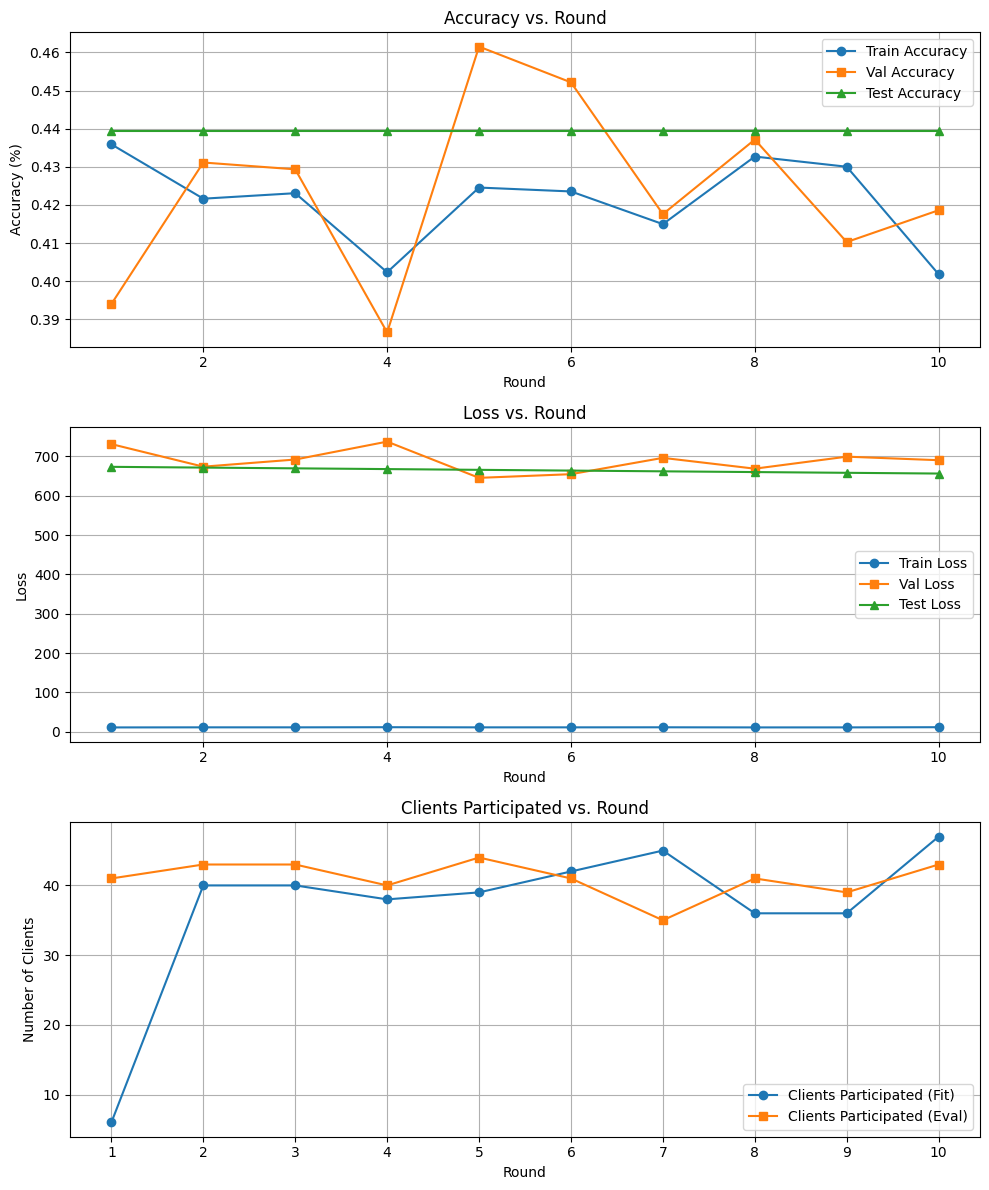

In [127]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(HISTORY["train_accuracy"]) + 1), HISTORY["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(HISTORY["val_accuracy"]) + 1), HISTORY["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(HISTORY["test_accuracy"]) + 1), HISTORY["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(HISTORY["train_loss"]) + 1), HISTORY["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(HISTORY["val_loss"]) + 1), HISTORY["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(HISTORY["test_loss"]) + 1), HISTORY["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(HISTORY["clients_participated_fit"]) + 1), HISTORY["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(HISTORY["clients_participated_eval"]) + 1), HISTORY["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(HISTORY["clients_participated_fit"]), len(HISTORY["clients_participated_eval"])) + 1))

plt.tight_layout()